In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
from string import punctuation
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

import spacy

from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

import contractions

In [69]:
sns.set_style('darkgrid')
sns.set_context('notebook')
sns.set_palette('tab10')

In [70]:
df = pd.read_csv('the_office_transcript.csv', index_col=0)
df

,season,episode,scene,line,character
0,1,1,1,All right Jim. Your quarterlies look very good...,Michael
1,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim
2,1,1,1,So you've come to the master for guidance? Is ...,Michael
3,1,1,1,"Actually, you called me in here, but yeah.",Jim
4,1,1,1,"All right. Well, let me show you how it's done.",Michael
...,...,...,...,...,...
59904,9,23,112,It all seems so very arbitrary. I applied for ...,Creed
59905,9,23,113,I just feel lucky that I got a chance to share...,Meredith
59906,9,23,114,I���m happy that this was all filmed so I can ...,Phyllis
59907,9,23,115,I sold paper at this company for 12 years. My ...,Jim


In [71]:
# Funkcja łącząca wypowiedzi w danej scenie
def combine_scene_lines(df):
    df['season_episode'] = df['season'].apply(lambda x: f's{x:02d}') + df['episode'].apply(lambda x: f'e{x:02d}')

    grouped_data = df.groupby(['season_episode', 'scene']).agg({
        'character': lambda x: set(x),
        'line': lambda x: ' '.join(x)
    }).reset_index()

    return grouped_data

In [72]:
combined_df = combine_scene_lines(df)
combined_df

,season_episode,scene,character,line
0,s01e01,1,"{Michael, Jim}",All right Jim. Your quarterlies look very good...
1,s01e01,2,{Michael},"[on the phone] Yes, I'd like to speak to your ..."
2,s01e01,3,"{Michael, Pam}","I've, uh, I've been at Dunder Mifflin for 12 y..."
3,s01e01,4,{Michael},"People say I am the best boss. They go, 'God w..."
4,s01e01,5,{Dwight},[singing] Shall I play for you? Pa rum pump um...
...,...,...,...,...
8844,s09e23,112,{Creed},It all seems so very arbitrary. I applied for ...
8845,s09e23,113,{Meredith},I just feel lucky that I got a chance to share...
8846,s09e23,114,{Phyllis},I���m happy that this was all filmed so I can ...
8847,s09e23,115,{Jim},I sold paper at this company for 12 years. My ...


In [73]:
combined_df.to_csv('combined_df.csv')

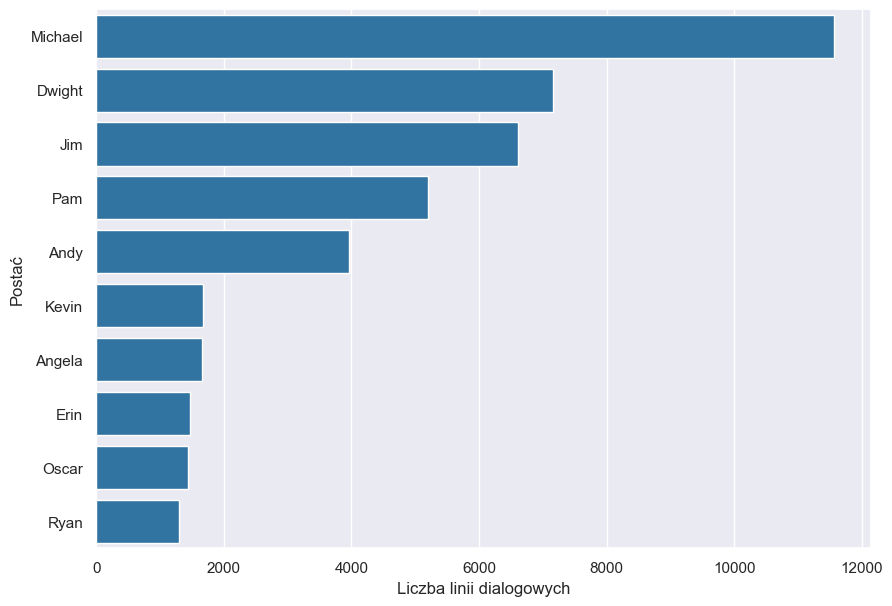

In [74]:
counts = df['character'].value_counts()[:10].sort_values(ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x=counts, y=counts.index)
# plt.title('Postaci najczęściej wypowiadające się w serialu "The Office"', fontsize=16)
plt.xlabel('Liczba linii dialogowych', fontsize=12)
plt.ylabel('Postać', fontsize=12)

plt.savefig('plots/top_postaci_total.pdf')

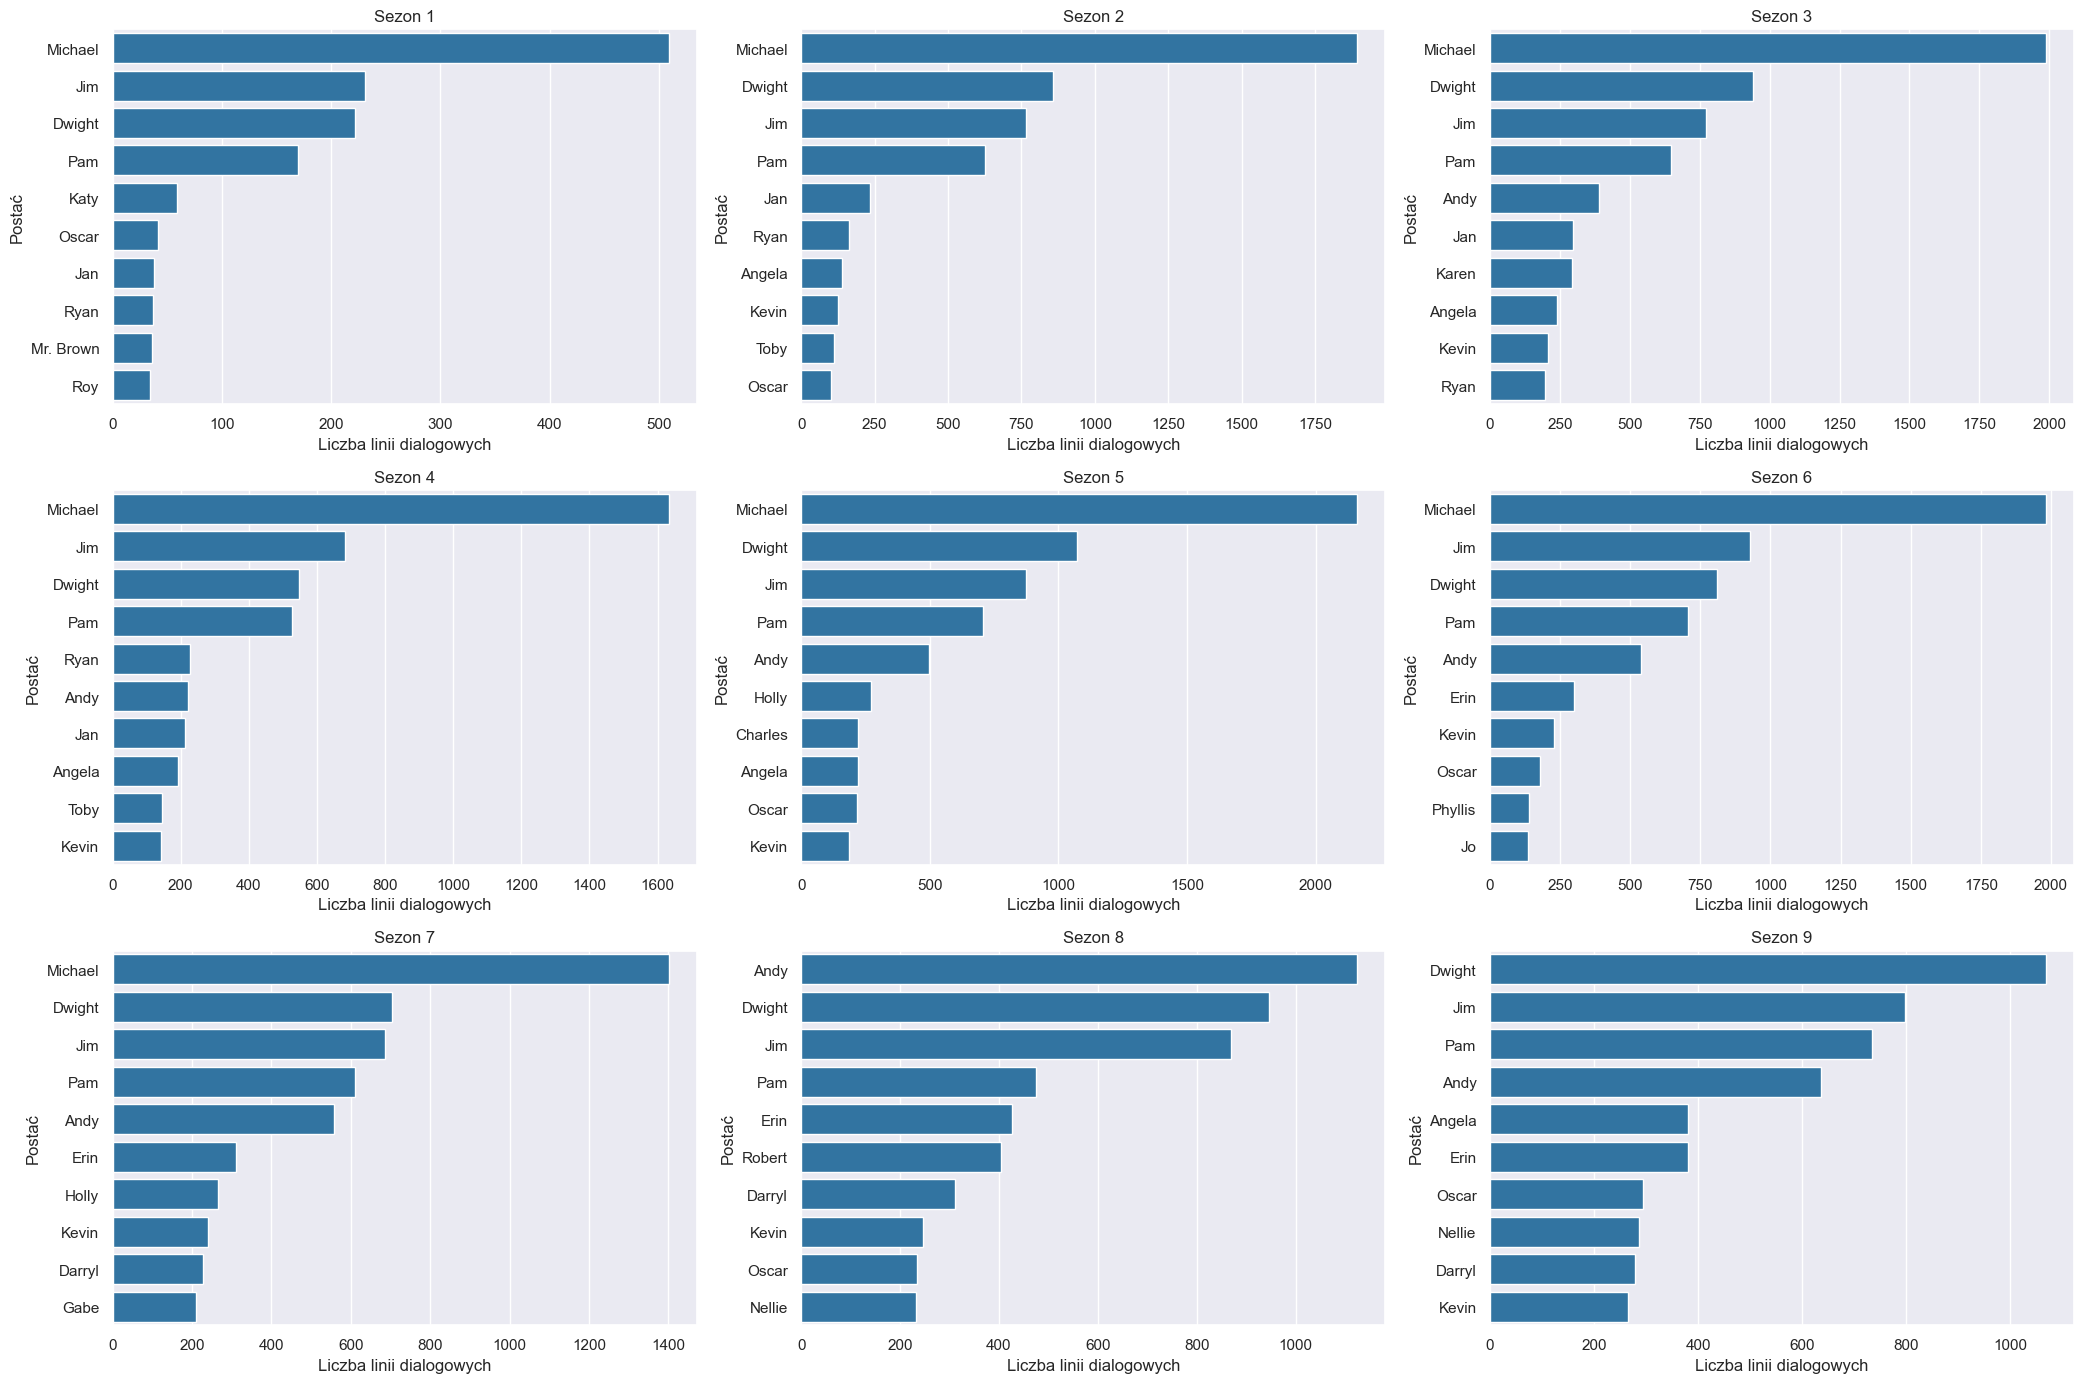

In [93]:
fig, ax = plt.subplots(3, 3, figsize=(21, 14))
for season in df['season'].unique():
    plt.subplot(3, 3, season)
    counts = df.loc[df.season == season, 'character'].value_counts()[:10].sort_values(ascending=False)
    sns.barplot(x=counts, y=counts.index)
    plt.title(f'Sezon {season}')
    plt.xlabel('Liczba linii dialogowych', fontsize=12)
    plt.ylabel('Postać', fontsize=12)
    
fig.tight_layout()
plt.savefig('plots/top_postaci_sezony.pdf')

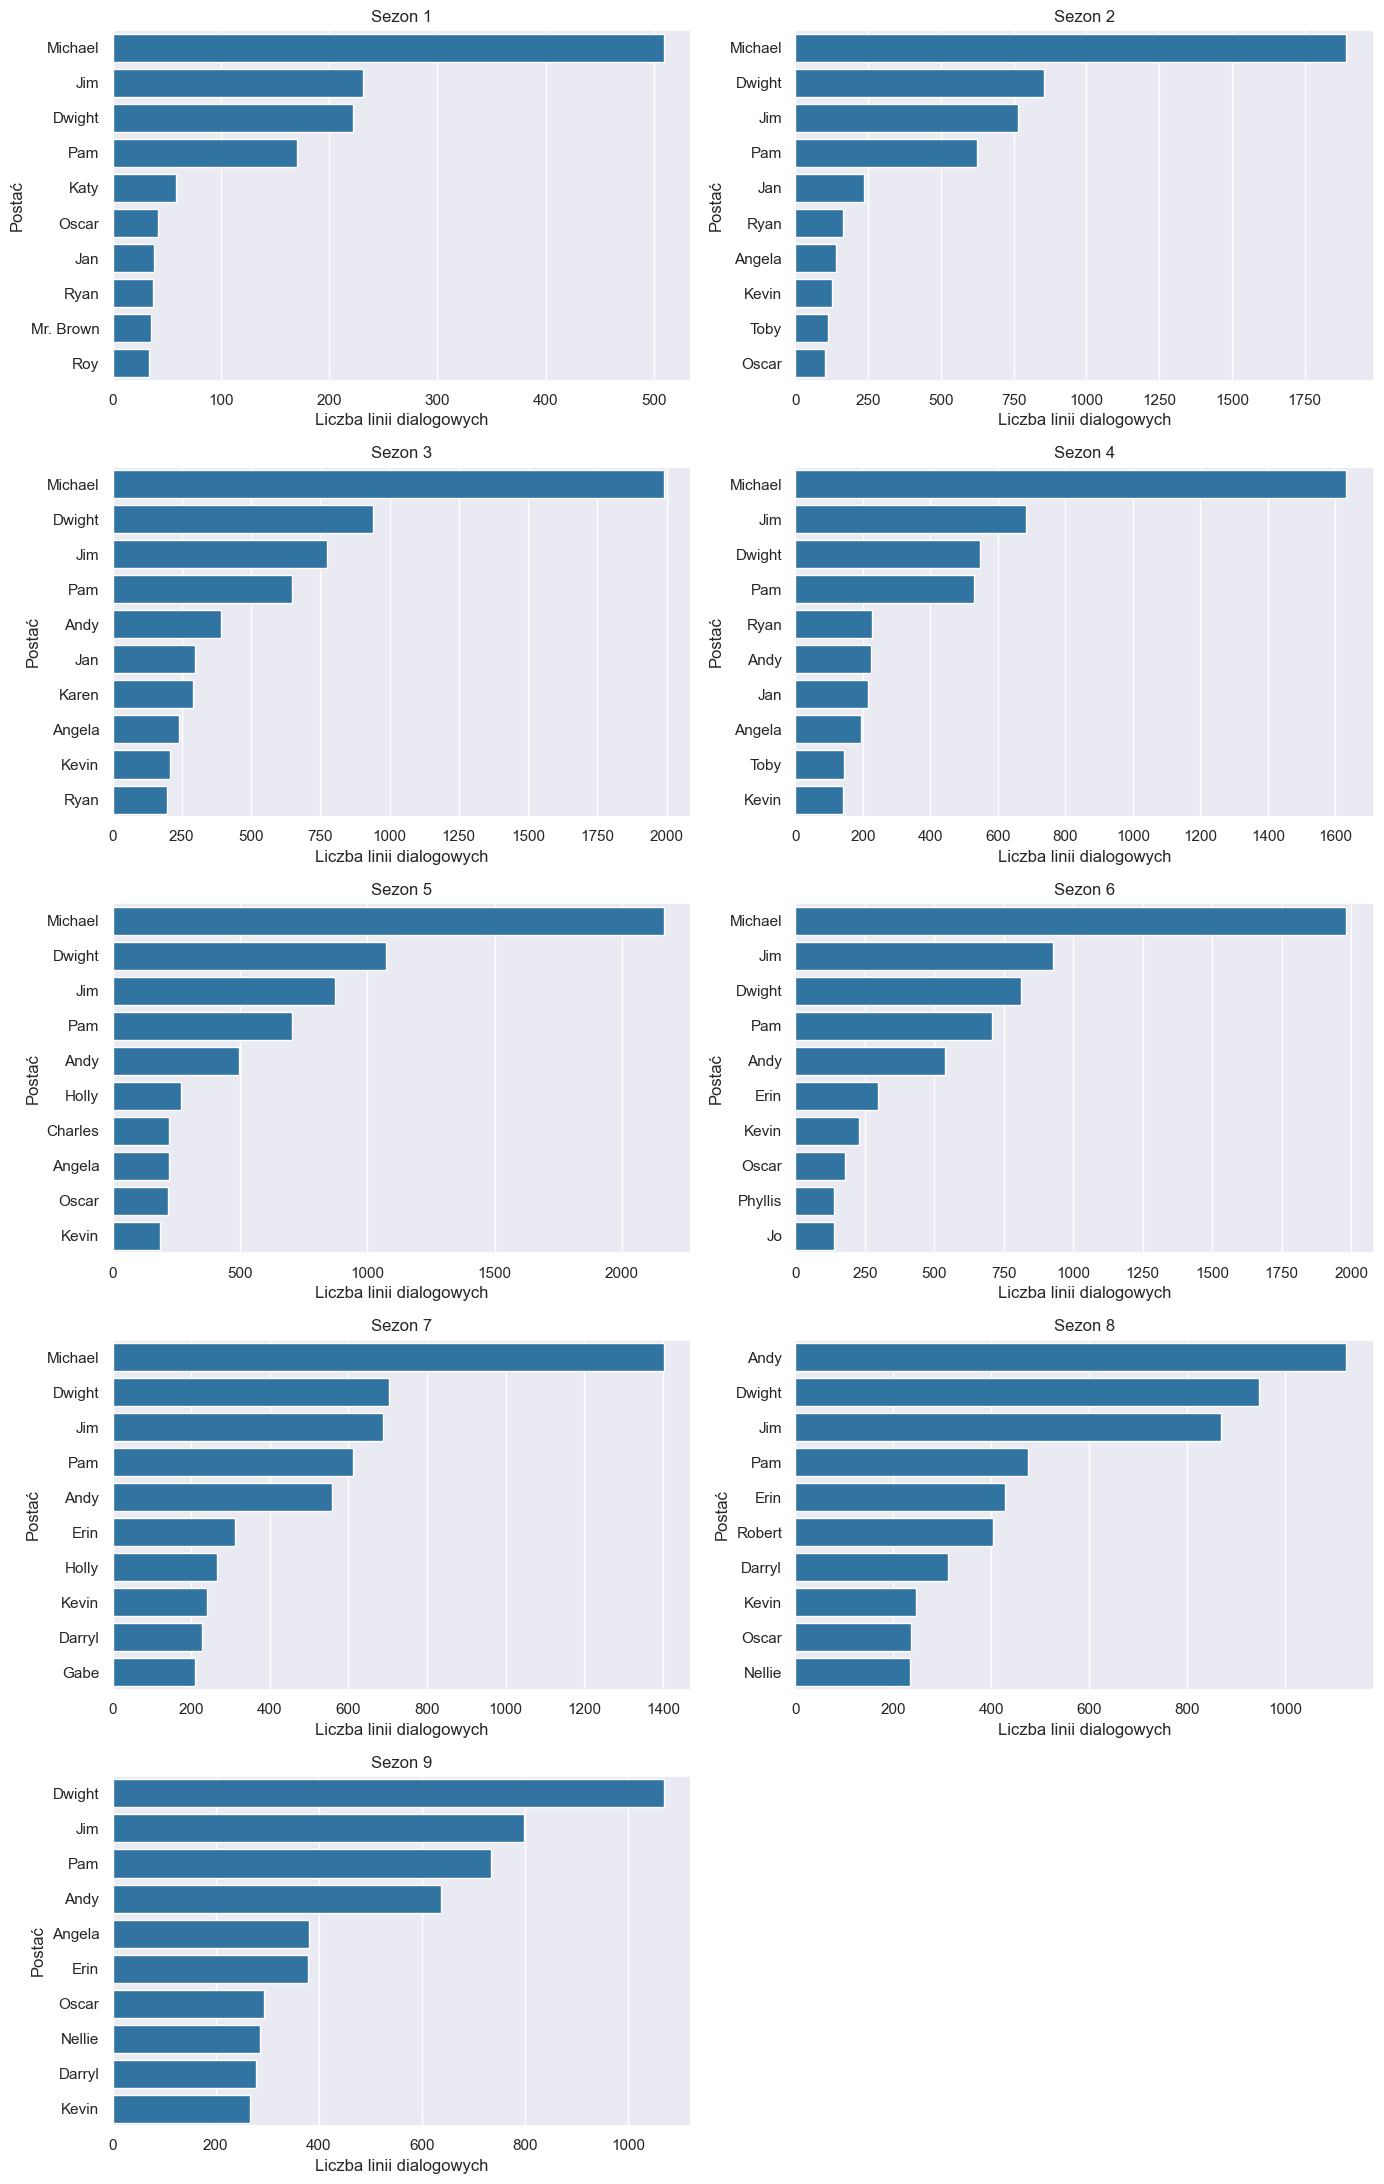

In [96]:
fig, axs = plt.subplots(5, 2, figsize=(14, 22))

unique_seasons = sorted(df['season'].unique())
for i, season in enumerate(unique_seasons):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    counts = df[df['season'] == season]['character'].value_counts().head(10)
    sns.barplot(x=counts.values, y=counts.index, ax=ax)
    ax.set_title(f'Sezon {season}')
    ax.set_xlabel('Liczba linii dialogowych')
    ax.set_ylabel('Postać')

if len(unique_seasons) < 10:
    axs[-1, -1].set_visible(False)

plt.tight_layout()
plt.savefig('plots/top_postaci_sezony_pionowo.pdf')

In [76]:
english_stopwords = stopwords.words('english')
custom_stopwords = ['oh', 'uh', 'um', 'yeah', 'okay', 'ok', 'right', 'alright', 'like', 'know', 'hey', 'gonna', 'huh', 'ah', 'ha', 'ay', 'ow', 
                    'hmm', 'mm', 'wow', 'whoa', 'em', 'ooh', 'umm']
english_stopwords.extend(custom_stopwords)

tidytext_stopwords = pd.read_csv(
    "https://raw.githubusercontent.com/juliasilge/tidytext/master/data-raw/stop_words.csv"
)
more_stopwords = list(tidytext_stopwords['word'])
english_stopwords.extend(more_stopwords)

nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'\[[^\]]*\]', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(f'[{re.escape(punctuation)}]', '', text)
    words = [word for word in text.split() if word not in english_stopwords]
    words = [word for word in words if len(word) > 2]
    lemmatized_words = [word.lemma_ for word in nlp(' '.join(words))]
    text = ' '.join(lemmatized_words)
    return text

In [77]:
df['line_preprocessed'] = df['line'].apply(lambda x: preprocess_text(x))
df

,season,episode,scene,line,character,season_episode,line_preprocessed
0,1,1,1,All right Jim. Your quarterlies look very good...,Michael,s01e01,jim quarterlies library
1,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,s01e01,tell close
2,1,1,1,So you've come to the master for guidance? Is ...,Michael,s01e01,master guidance grasshopper
3,1,1,1,"Actually, you called me in here, but yeah.",Jim,s01e01,call
4,1,1,1,"All right. Well, let me show you how it's done.",Michael,s01e01,
...,...,...,...,...,...,...,...
59904,9,23,112,It all seems so very arbitrary. I applied for ...,Creed,s09e23,arbitrary apply job company hiring desk empty ...
59905,9,23,113,I just feel lucky that I got a chance to share...,Meredith,s09e23,feel lucky chance share crummy story dump pape...
59906,9,23,114,I���m happy that this was all filmed so I can ...,Phyllis,s09e23,happy filmed remember paper company write
59907,9,23,115,I sold paper at this company for 12 years. My ...,Jim,s09e23,sell paper company job speak client phone quan...


In [78]:
def get_top_n_words(text, n_words=10):
    words = text.split()
    word_counts = Counter(words)
    top_words = [word[0] for word in word_counts.most_common(n_words)]
    return top_words

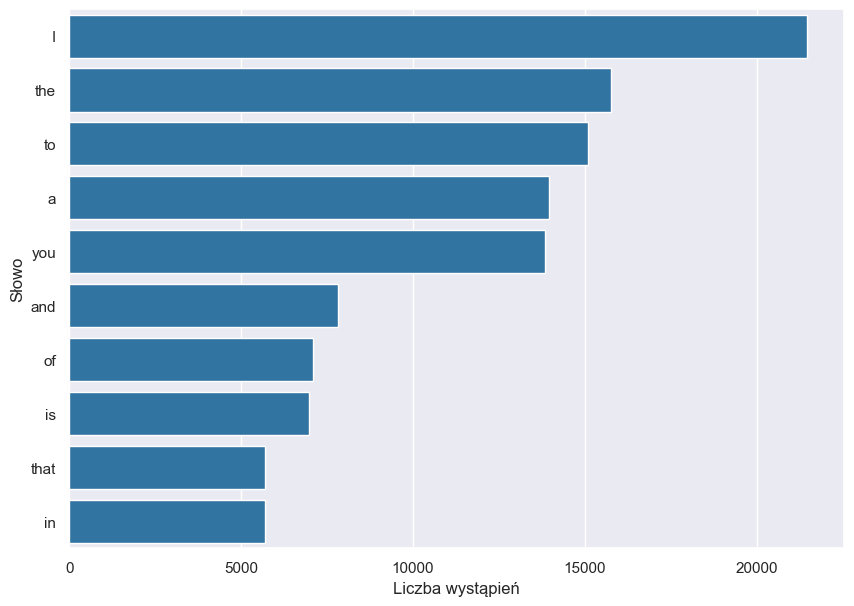

In [79]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 12))
plt.figure(figsize=(10, 7))

all_lines = ' '.join(df['line'])
top_words = get_top_n_words(all_lines)
counts = [all_lines.split().count(word) for word in top_words]

sns.barplot(x=counts, y=top_words)
# ax1.set_title('Top words in the dataset before preprocessing', fontsize=16)
plt.xlabel('Liczba wystąpień', fontsize=12)
plt.ylabel('Słowo', fontsize=12)
plt.savefig('plots/top_slowa_przed.pdf')

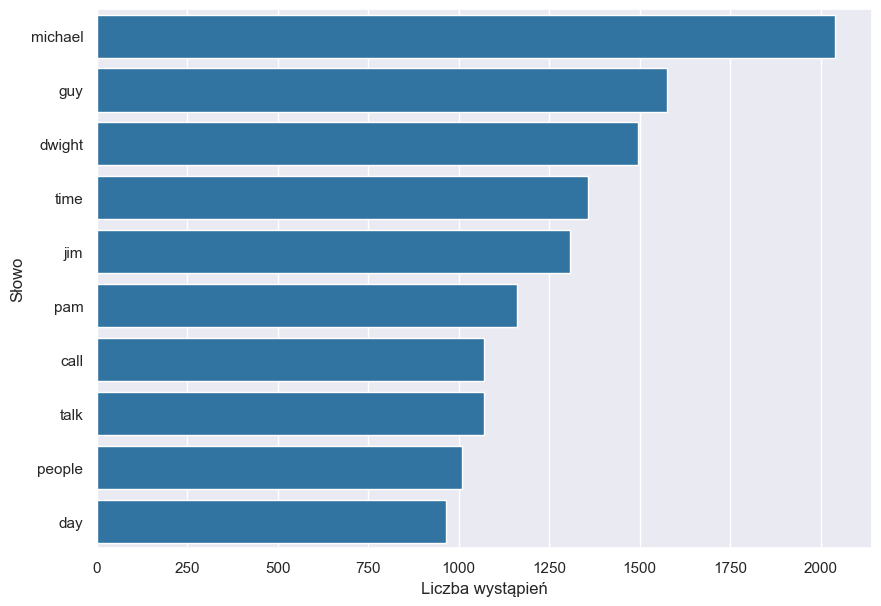

In [80]:
plt.figure(figsize=(10, 7))
all_lines = ' '.join(df['line_preprocessed'])
top_words = get_top_n_words(all_lines)
counts = [all_lines.split().count(word) for word in top_words]

sns.barplot(x=counts, y=top_words)
# ax2.set_title('Top words in the dataset after preprocessing', fontsize=16)
plt.xlabel('Liczba wystąpień', fontsize=12)
plt.ylabel('Słowo', fontsize=12)
# plt.tight_layout()

plt.savefig('plots/top_slowa_po.pdf')

In [81]:
top_characters = list(df['character'].value_counts()[:10].sort_values(ascending=False).index)

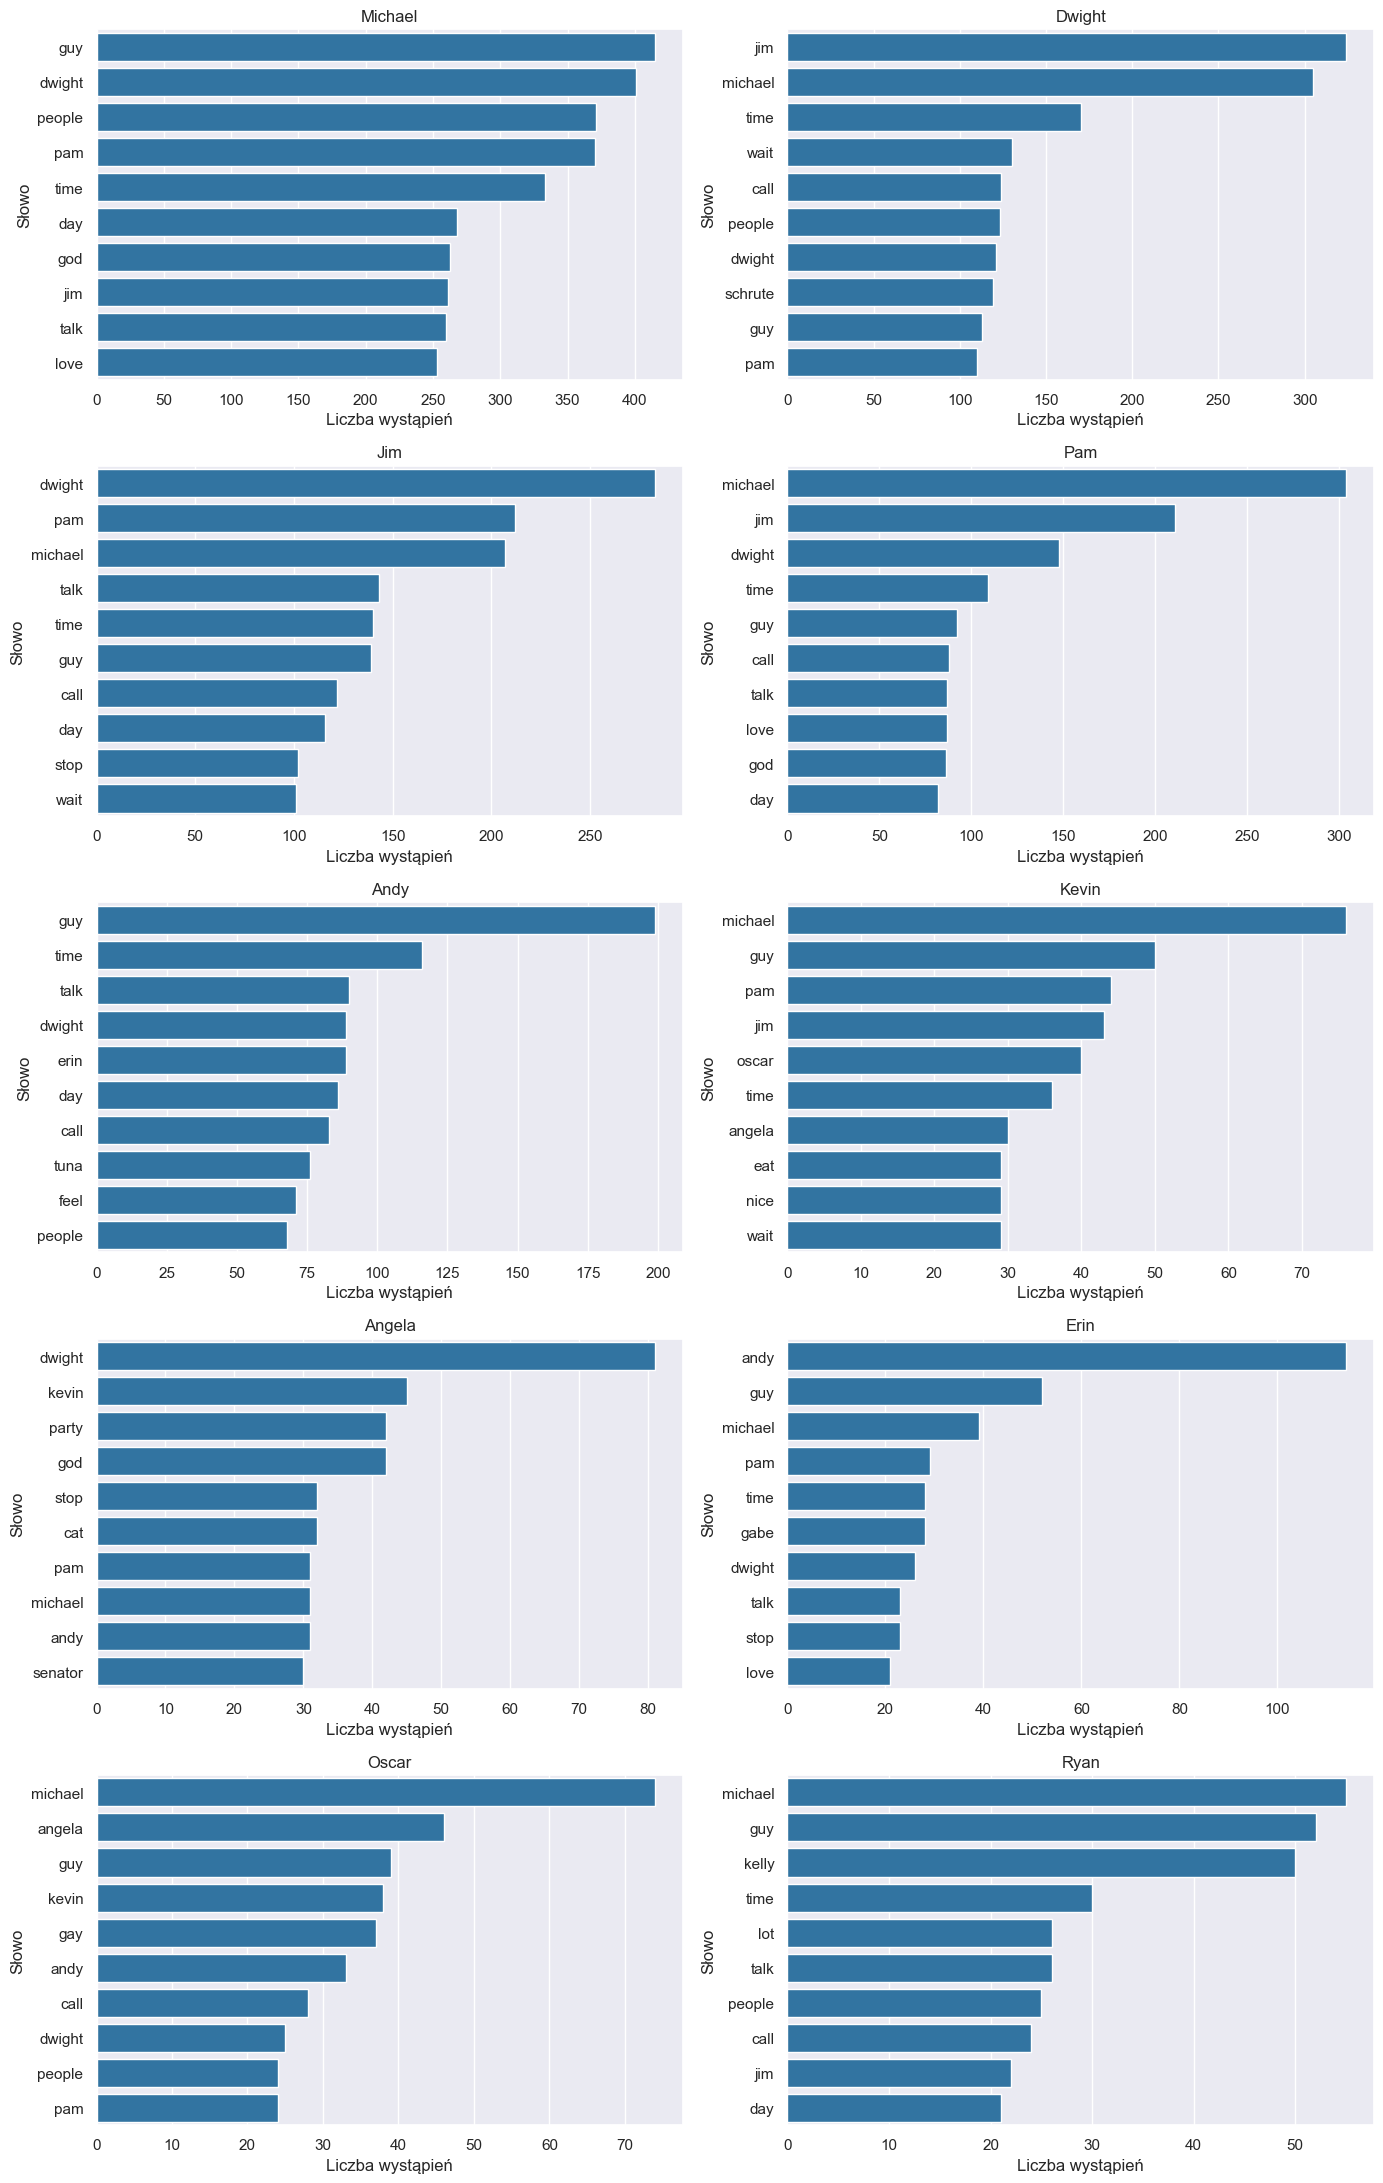

In [84]:
fig, axs = plt.subplots(5, 2, figsize=(14, 22))
index = 1

for index, character in enumerate(top_characters):
    ax = axs[index // 2, index % 2]
    lines = df.loc[df['character'] == character, 'line_preprocessed']
    all_lines = ' '.join(lines.tolist()) 
    top_words = get_top_n_words(all_lines)
    counts = [all_lines.split().count(word) for word in top_words]
    sns.barplot(x=counts, y=top_words, ax=ax)
    ax.set_title(character)
    ax.set_xlabel('Liczba wystąpień')
    ax.set_ylabel('Słowo')
    
# plt.suptitle('Top words by characters', fontsize=24)
fig.tight_layout()

plt.savefig('plots/top_slowa_postaci.pdf')

In [38]:
df = df[df['line_preprocessed'].map(lambda d: len(d)) > 0]
df.to_csv('preprocessed_df.csv')
df

,season,episode,scene,line,character,season_episode,line_preprocessed
0,1,1,1,All right Jim. Your quarterlies look very good...,Michael,s01e01,jim quarterlies library
1,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,s01e01,tell close
2,1,1,1,So you've come to the master for guidance? Is ...,Michael,s01e01,master guidance grasshopper
3,1,1,1,"Actually, you called me in here, but yeah.",Jim,s01e01,call
5,1,1,2,"[on the phone] Yes, I'd like to speak to your ...",Michael,s01e01,speak office manager michael scott regional ma...
...,...,...,...,...,...,...,...
59904,9,23,112,It all seems so very arbitrary. I applied for ...,Creed,s09e23,arbitrary apply job company hiring desk empty ...
59905,9,23,113,I just feel lucky that I got a chance to share...,Meredith,s09e23,feel lucky chance share crummy story dump pape...
59906,9,23,114,I���m happy that this was all filmed so I can ...,Phyllis,s09e23,happy filmed remember paper company write
59907,9,23,115,I sold paper at this company for 12 years. My ...,Jim,s09e23,sell paper company job speak client phone quan...


In [39]:
def get_top_unique_ngrams(n_words=10, ngram_range=(1,1)):
    lines_by_character = df.groupby('character')['line_preprocessed'].apply(lambda x: ' '.join(x))

    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_df=0.02)
    tfidf = vectorizer.fit_transform(lines_by_character.values)

    tfidf_characters = ['Michael', 'Jim', 'Dwight', 'Pam', 'Andy', 'Ryan', 'Kelly', 'Kevin', 'Toby', 
                        'Angela', 'Erin', 'Oscar', 'Phyllis', 'Creed', 'Stanley', 'Meredith', 'Darryl']
    
    unique_words = {}

    feature_names = vectorizer.get_feature_names_out()
    for i, character in enumerate(lines_by_character.index):
        if character in tfidf_characters:
            tfidf_scores = tfidf[i, :].toarray()[0]
            top_indices = tfidf_scores.argsort()[-n_words:][::-1]
            top_words = {}
            for j in top_indices:
                top_words[feature_names[j]] =  tfidf_scores[j]

            unique_words[character] = top_words
    return unique_words

In [97]:
def plot_top_unique_ngrams(ngram_range, ylabel, path):
    top_unique_ngrams = get_top_unique_ngrams(n_words=10, ngram_range=ngram_range)

    fig, axs = plt.subplots(5, 2, figsize=(14, 22))
    index = 1
    for index, character in enumerate(top_characters):
        ax = axs[index // 2, index % 2]
        top_words = list(top_unique_ngrams[character].keys())
        counts = list(top_unique_ngrams[character].values())
        sns.barplot(x=counts, y=top_words, ax=ax)
        plt.title(character)
        plt.xlabel('Wartość TF-IDF')
        plt.ylabel(ylabel)
        index += 1

    # plt.suptitle(title, fontsize=24)
    fig.tight_layout()
    # plt.show()
    plt.savefig(path)

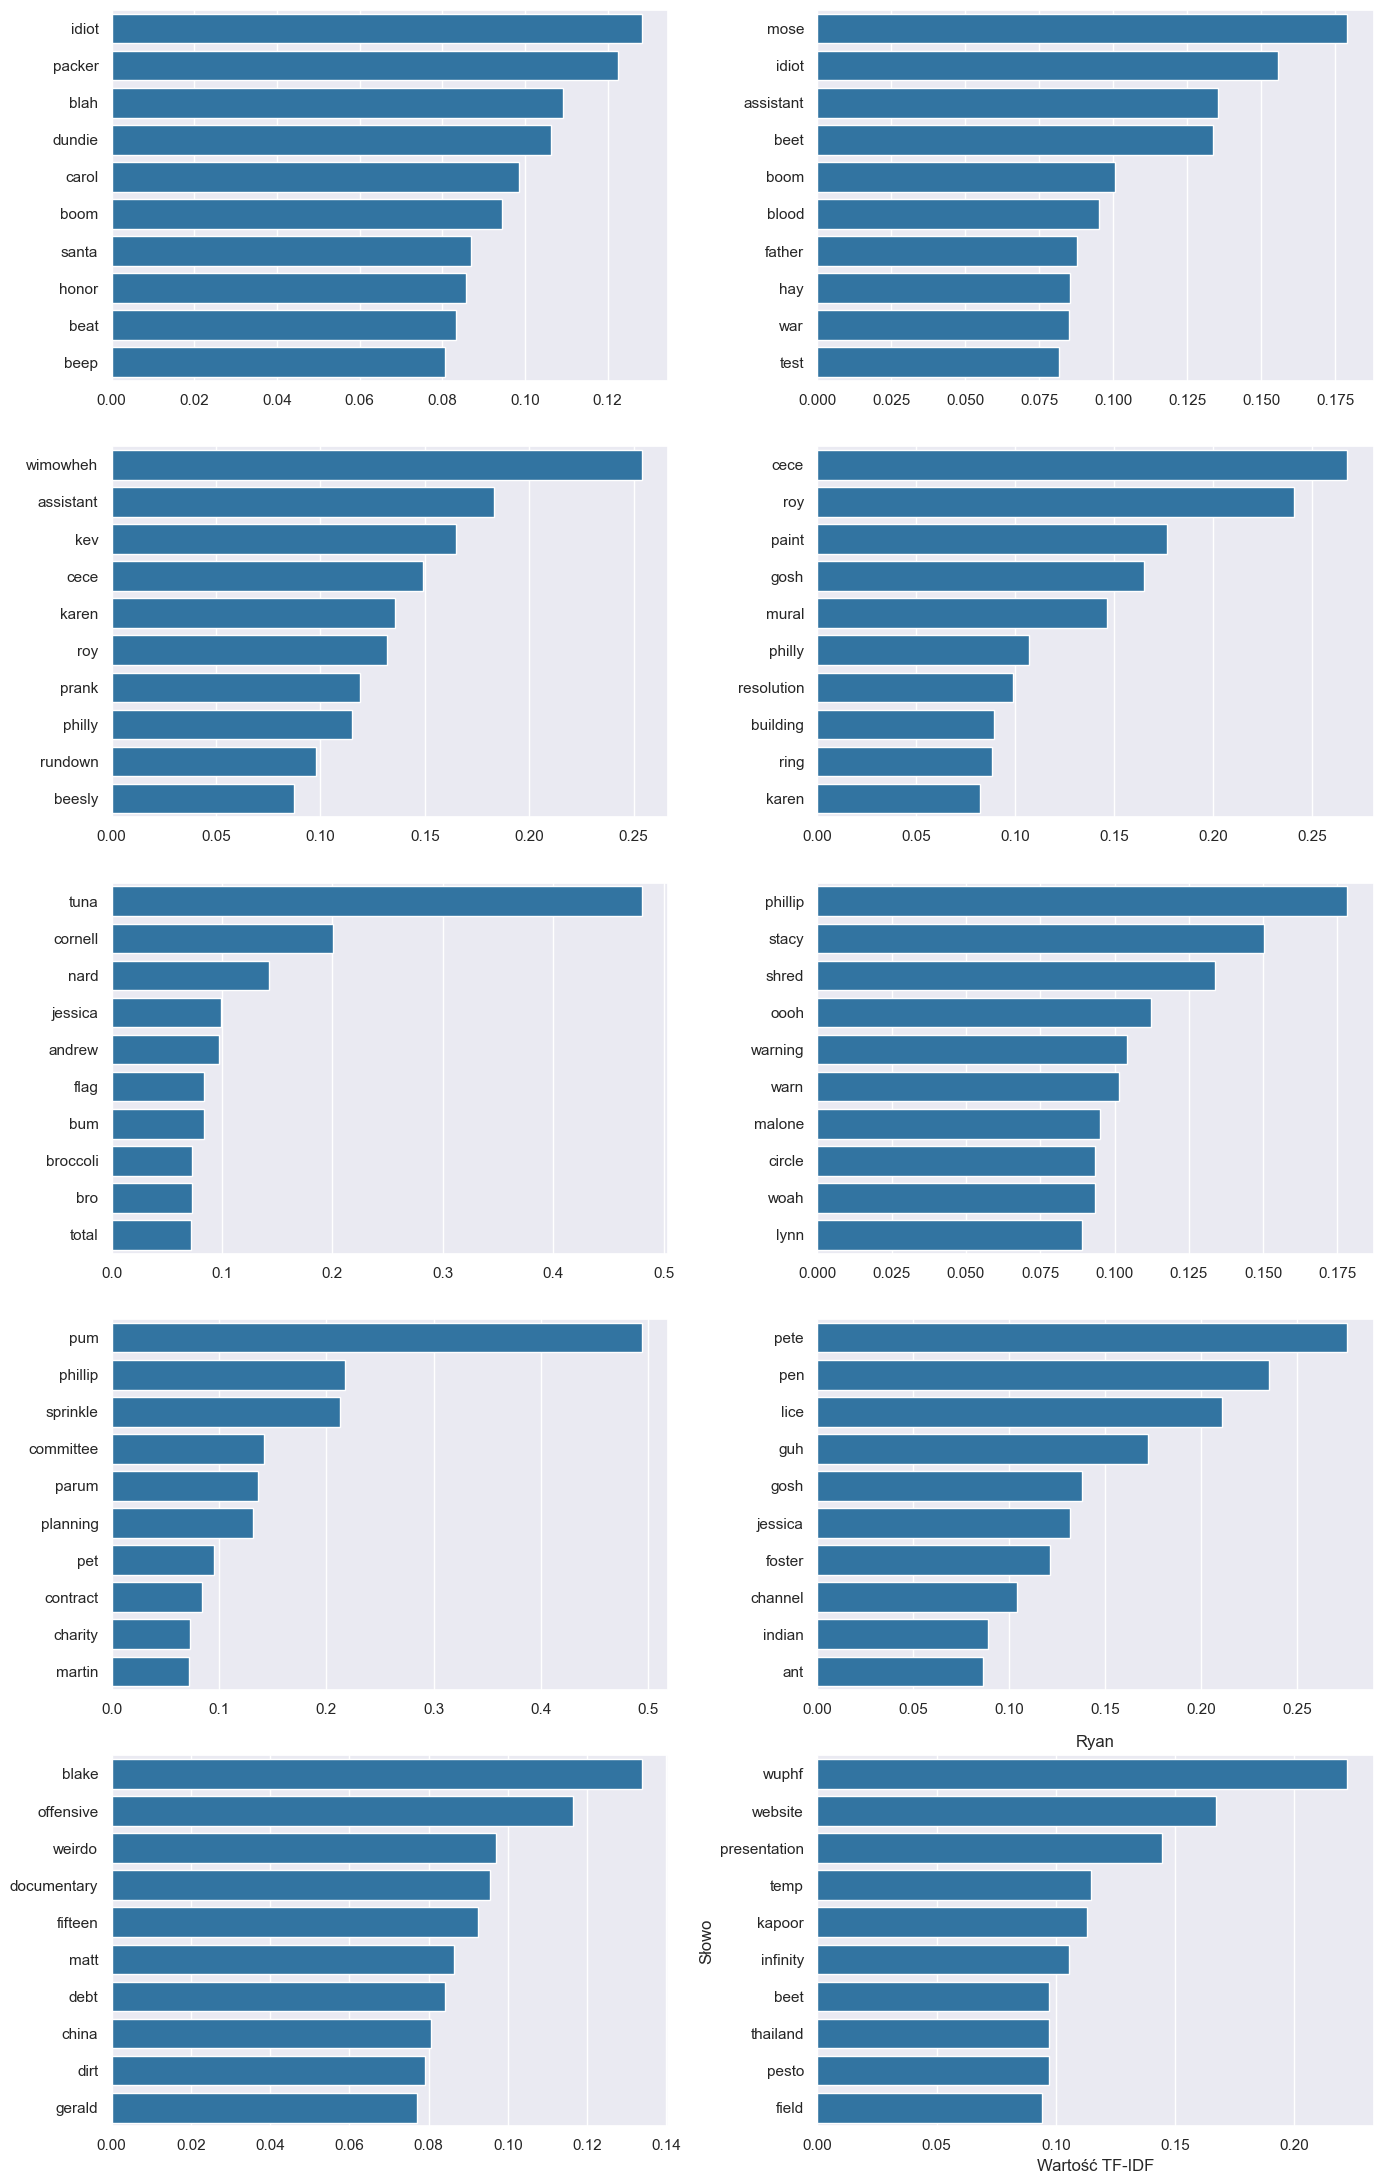

In [98]:
plot_top_unique_ngrams(ngram_range=(1,1), ylabel='Słowo', path='plots/top_slowa_tfidf.pdf')

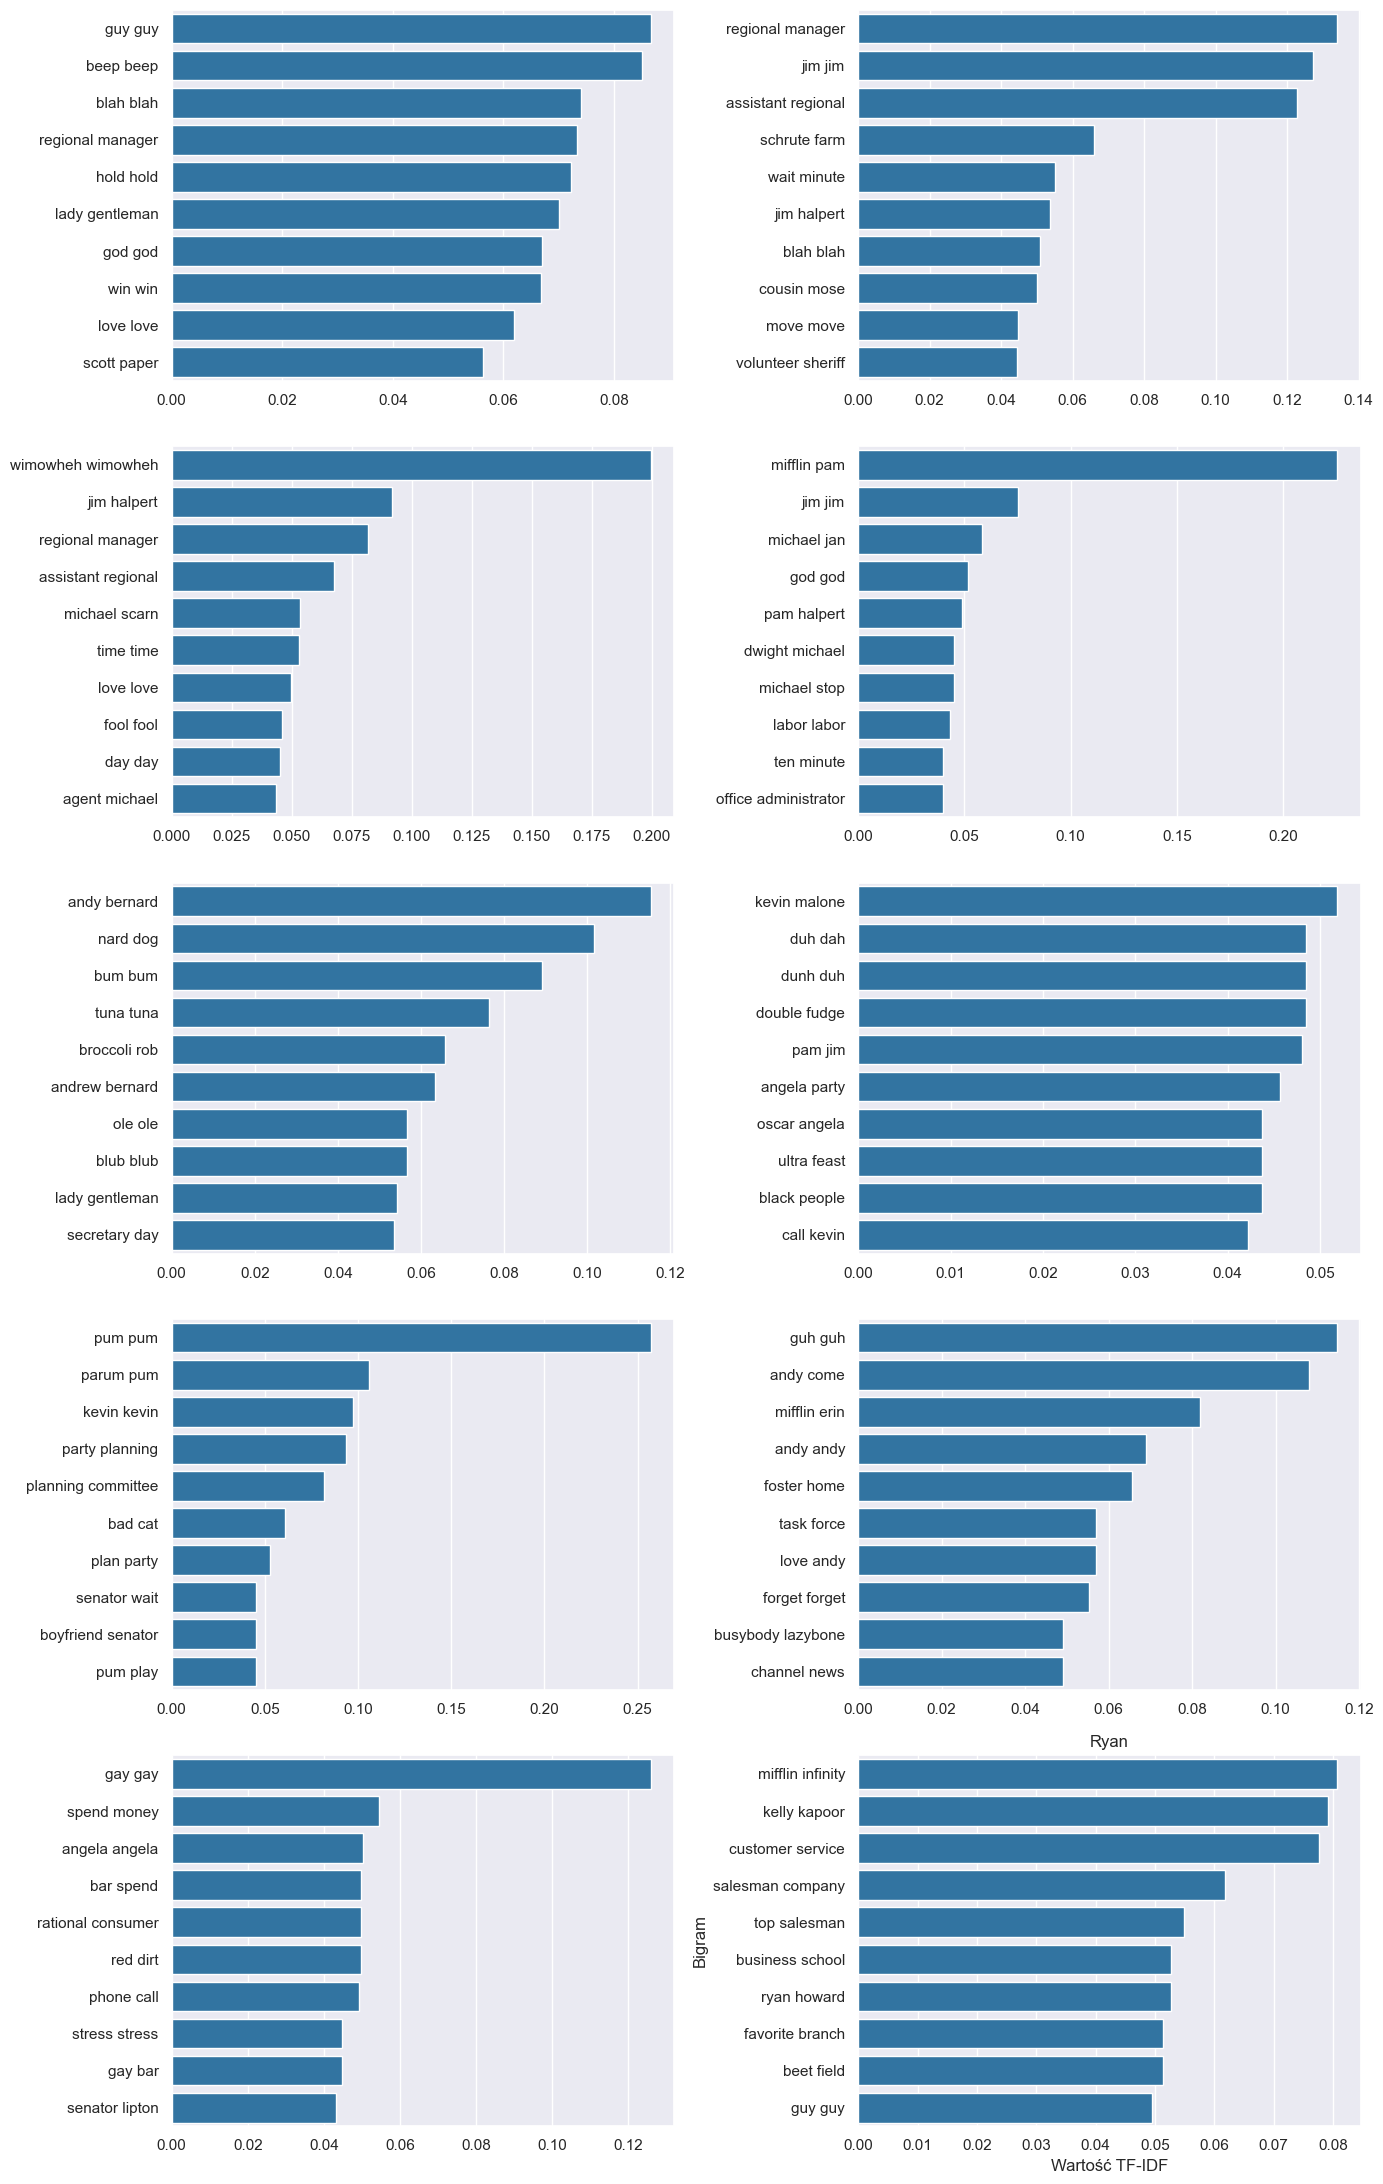

In [99]:
plot_top_unique_ngrams(ngram_range=(2,2), ylabel='Bigram', path='plots/top_bigramy_tfidf.pdf')

In [85]:
def generate_wordcloud(character, img_path=None, out_path=None):
    
    unique_words = get_top_unique_ngrams(n_words=100, ngram_range=(1,1))
    word_dict = unique_words[character]
        
    mask = np.array(Image.open(img_path))    
    wordcloud = WordCloud(width=800, height=400, background_color='white', mode='RGBA', mask=mask).generate_from_frequencies(word_dict)
    
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[7,7])
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
    wordcloud.to_file(out_path)
    plt.axis('off')
    plt.show()

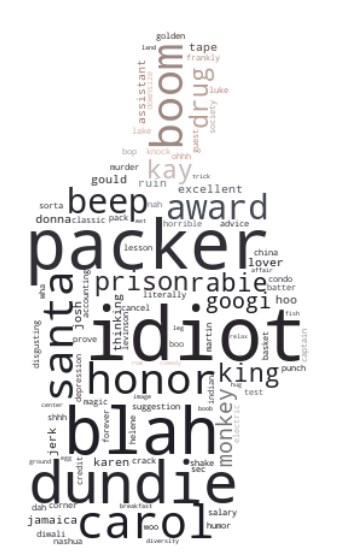

In [86]:
generate_wordcloud(character='Michael', img_path='img/michael.png', out_path='output/tfidf_michael.png')

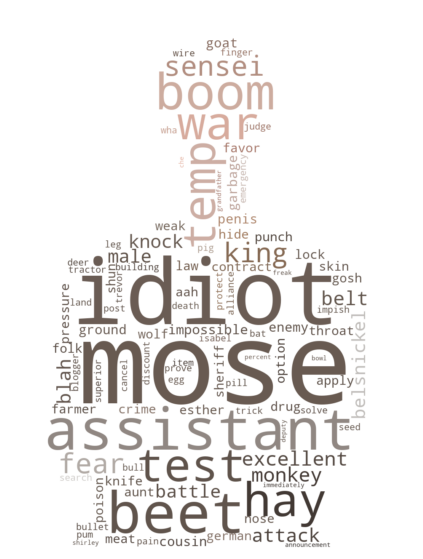

In [87]:
generate_wordcloud(character='Dwight', img_path='img/dwight.png', out_path='output/tfidf_dwight.png')

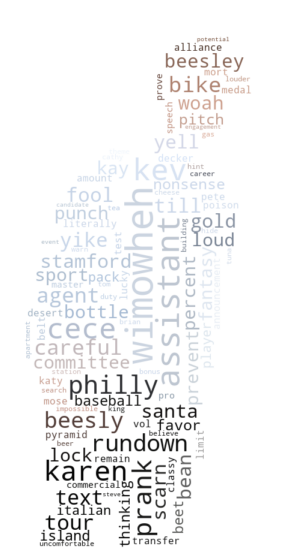

In [88]:
generate_wordcloud(character='Jim', img_path='img/jim.png', out_path='output/tfidf_jim.png')

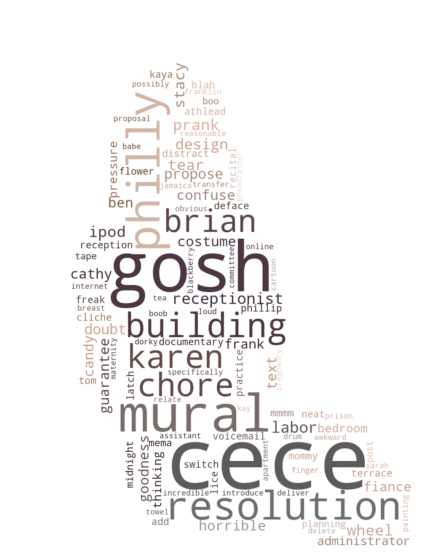

In [89]:
generate_wordcloud(character='Pam', img_path='img/pam.png', out_path='output/tfidf_pam.png')

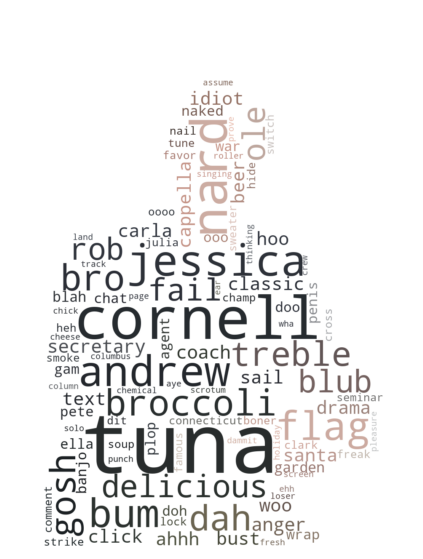

In [90]:
generate_wordcloud(character='Andy', img_path='img/andy.png', out_path='output/tfidf_andy.png')

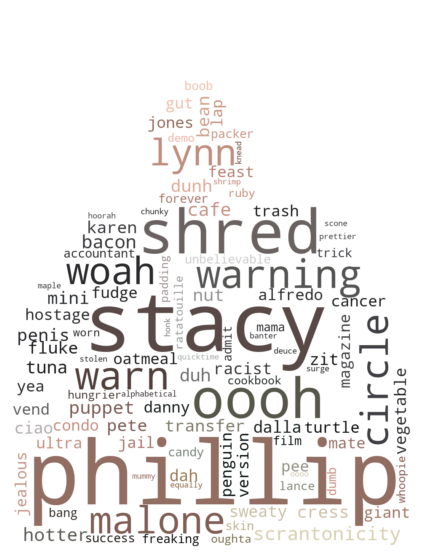

In [91]:
generate_wordcloud(character='Kevin', img_path='img/kevin.png', out_path='output/tfidf_kevin.png')

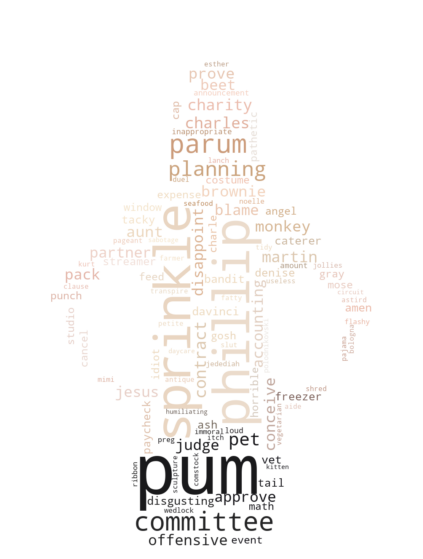

In [92]:
generate_wordcloud(character='Angela', img_path='img/angela.png', out_path='output/tfidf_angela.png')

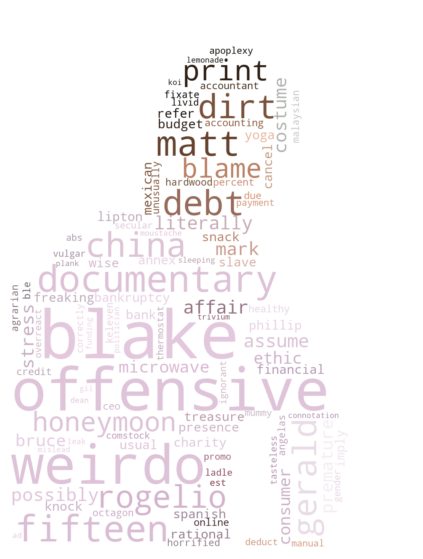

In [93]:
generate_wordcloud(character='Oscar', img_path='img/oscar.png', out_path='output/tfidf_oscar.png')

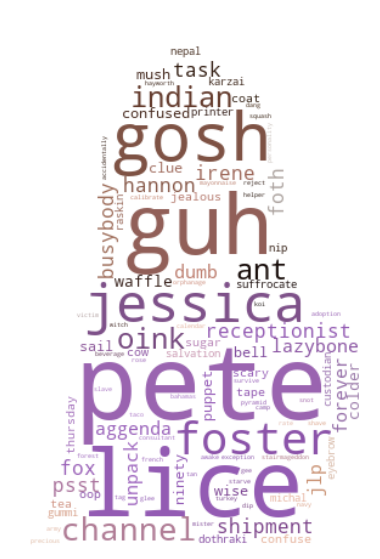

In [94]:
generate_wordcloud(character='Erin', img_path='img/erin.png', out_path='output/tfidf_erin.png')

## TF-IDF for seasons

In [35]:
def get_top_unique_ngrams_by_season(n_words=10, ngram_range=(1,1)):
    lines_by_season = df.groupby('season')['line_preprocessed'].apply(lambda x: ' '.join(x))

    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_df=0.5)
    tfidf = vectorizer.fit_transform(lines_by_season.values)

    seasons = df['season'].unique()
    
    unique_words = {}

    feature_names = vectorizer.get_feature_names_out()
    for i, season in enumerate(lines_by_season.index):
        if season in seasons:
            tfidf_scores = tfidf[i, :].toarray()[0]
            top_indices = tfidf_scores.argsort()[-n_words:][::-1]
            top_words = {}
            for j in top_indices:
                top_words[feature_names[j]] = tfidf_scores[j]

            unique_words[season] = top_words
    return unique_words

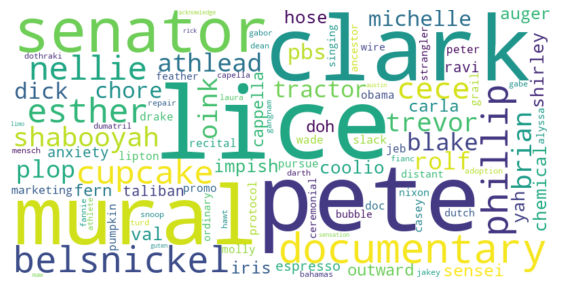

In [50]:
# for season in range(1,10):
#     unique_words = get_top_unique_ngrams_by_season(n_words=50, ngram_range=(1,1))
#     word_dict = unique_words[season]
#     print(season)
#     print(word_dict)

season = 9
unique_words = get_top_unique_ngrams_by_season(n_words=100, ngram_range=(1,1))
word_dict = unique_words[season]

wordcloud = WordCloud(width=800, height=400, background_color='white', mode='RGBA').generate_from_frequencies(word_dict)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()